# Methodology VCT

In [2]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored

import paper

In [19]:
ship_name = "wPCC"
model = catalog.load(f"{ship_name}.models_VCT_polynomial_rudder_MDL")['simple']()

[11/19/24 11:15:19] INFO     Loading data from 'wPCC.models_VCT_polynomial_rudder_MDL'          ]8;id=511908;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=86006;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [147]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")
#df_VCT = model.prime(data=df_VCT)
mask = df_VCT['test type'] == 'Rudder angle resistance (no propeller)'
df_VCT = df_VCT.loc[~mask].copy()

df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])

[11/19/24 13:50:15] INFO     Loading data from 'wPCC.df_VCT_scaled' (CSVDataSet)...             ]8;id=502698;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=376949;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [148]:
meta_data_all = catalog.load(f"{ship_name}.time_series_meta_data")
id_exists = [int(key) for key in catalog.load(f"{ship_name}.tests_ek_smooth1").keys()]
meta_data_all = meta_data_all.loc[id_exists].copy()
#ids = [int(key) for key in catalog.load("wPCC.tests_ek_smooth1").keys()]
ids = [
        22773,
       # 22772,
        22770,
        #22765,
        #22774,
    ]

meta_datas = meta_data_all.loc[ids].copy()


[11/19/24 13:50:16] INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=220204;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=814786;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=790181;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=459876;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [149]:

dataframes = {}
for id, meta_data in meta_datas.iterrows():

    df_EKF_smooth = catalog.load("wPCC.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    df_EKF_smooth['thrust'] = df_EKF_smooth['thrust_port'] + df_EKF_smooth['thrust_stbd']

    #df_EKF_smooth = model.prime(df_EKF_smooth)
    
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    dataframes[name] = df_EKF_smooth

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=631498;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=244497;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=45521;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=951680;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [150]:
df_VCT_mirrored = add_mirrored(df_VCT)
df_VCT_mirrored['beta_deg'] = np.rad2deg(df_VCT_mirrored['beta'])

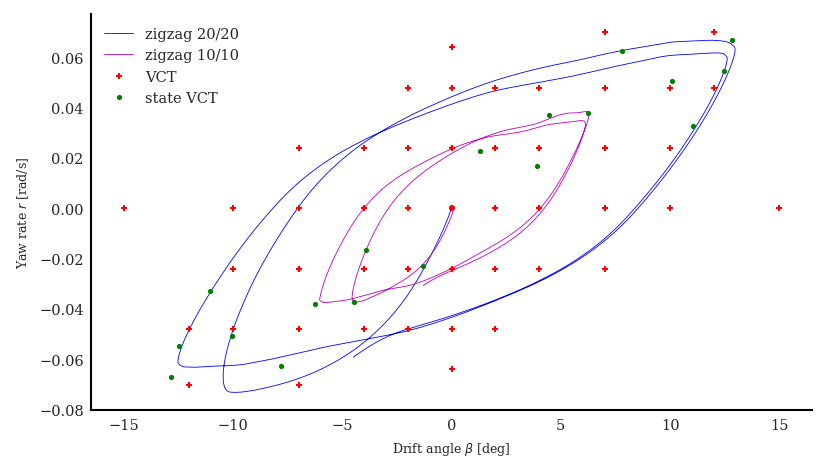

In [151]:
fig,ax=plt.subplots()

colors = ['b','m']
for name,data in dataframes.items():

    data['beta_deg'] = np.rad2deg(data['beta'])
    data.plot(x='beta_deg',y='r', color=colors.pop(0), ax=ax, label=name)

mask = df_VCT_mirrored['name'].str.contains('state_')
df_VCT_mirrored.loc[~mask].plot(x='beta_deg', y='r', style='r+', label='VCT', ax=ax)
df_VCT_mirrored.loc[mask].plot(x='beta_deg', y='r', style='g.', label='state VCT', ax=ax)

ax.set_xlabel(r'Drift angle $\beta$ [deg]')
#ax.set_ylabel(r"Yaw rate $r'$ [-]")
ax.set_ylabel(r"Yaw rate $r$ [rad/s]")

ax.legend(loc='upper left')
paper.save_fig(fig,"phase_plot.svg")

In [152]:
df_VCT['test type'].unique()


array(['Circle', 'Circle + Drift', 'Circle + Drift + rudder angle',
       'Circle + rudder angle', 'Drift angle', 'Rudder and drift angle',
       'Rudder angle', 'Thrust variation', 'self propulsion'],
      dtype=object)

In [153]:
df_VCT[['test type','V','beta_deg','r','delta','rev']]

,test type,V,beta_deg,r,delta,rev
2,Circle,0.961770,0.00000,-0.063932,-0.000000,8.794787
3,Circle,0.961770,0.00000,-0.047949,-0.000000,8.794787
4,Circle,0.961770,0.00000,-0.023974,-0.000000,8.794787
6,Circle + Drift,0.961770,-12.00000,-0.069998,-0.000000,8.794787
7,Circle + Drift,0.961770,-7.00000,-0.069998,-0.000000,8.794787
8,Circle + Drift,0.961770,-12.00000,-0.047949,-0.000000,8.794787
9,Circle + Drift,0.961770,-7.00000,-0.047949,-0.000000,8.794787
10,Circle + Drift,0.961770,-7.00000,-0.023974,-0.000000,8.794787
11,Circle + Drift,0.961770,2.00000,-0.047949,-0.000000,8.794787
12,Circle + Drift,0.961770,2.00000,-0.023974,-0.000000,8.794787


In [154]:
keys=['V','beta_deg','r','delta_deg','rev']
df_VCT_mirrored['delta_deg'] = np.rad2deg(df_VCT_mirrored['delta'])

In [155]:
df_VCT.groupby(by='test type').get_group('Thrust variation')['rev']


44     7.358250
45     8.108395
46    10.027600
47     3.794727
48     4.181568
49     5.171325
Name: rev, dtype: float64

In [156]:
df_mins = df_VCT_mirrored.groupby(by='test type').min()[keys]
df_maxs = df_VCT_mirrored.groupby(by='test type').max()[keys]
df_first = df_VCT_mirrored.groupby(by='test type').first()[keys]

In [157]:
min = df_mins.iloc[0]
max = df_maxs.iloc[0]
mask = min!=max
min[mask].index

Index(['r'], dtype='object')

In [158]:
_ = []
key_decimals={
    'beta_deg':0,
    'delta_deg':0,
    'rev':1
}
for index, min in df_mins.iterrows():
    max = df_maxs.loc[index]
    mask = min!=max
    
    
    #s = pd.Series(name=index)
    s = df_first.loc[index].apply(lambda x: f"{x:0.2f}" if x > 0 else "")
    for key in min[mask].index:
        decimals = key_decimals.get(key,2)
        s[key] = f"{min[key]:0.{decimals}f} -- {max[key]:0.{decimals}f}"

    _.append(s)
    

In [159]:
df_variations = pd.DataFrame(_)
df_variations.index.name='Test type'

In [160]:
df_variations

,V,beta_deg,r,delta_deg,rev
Test type,,,,,
Circle,0.96,,-0.06 -- 0.06,,8.79
Circle + Drift,0.96,-12 -- 12,-0.07 -- 0.07,,8.79
Circle + Drift + rudder angle,0.78 -- 0.96,-13 -- 13,-0.07 -- 0.07,-20 -- 20,7.2 -- 8.8
Circle + rudder angle,0.96,,-0.05 -- 0.05,-10 -- 10,8.79
Drift angle,0.96,-15 -- 15,,,8.79
Rudder and drift angle,0.96,-4 -- 4,,-10 -- 10,8.79
Rudder angle,0.96,,,-15 -- 15,8.79
Thrust variation,0.48 -- 0.96,,,-10 -- 10,3.8 -- 10.0
self propulsion,0.48 -- 0.96,,,,4.6 -- 8.8


In [161]:
df_variations.to_csv(paper.file_path_with_nb_ref("variations.csv", directory='tables'), index=True)